Objectif: estimer le nutriscore d'un produit

## Imports and config

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re, requests
from tqdm import tqdm

In [4]:
warnings.filterwarnings('ignore')
tqdm.pandas()
pd.set_option("display.max_columns", 200)

In [5]:
filepath = '../data/en.openfoodfacts.org.products.pkl'
df = pd.read_pickle(filepath)

## EDA

In [6]:
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615984 entries, 0 to 1615983
Data columns (total 184 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   code                                        1615984 non-null  object 
 1   url                                         1615984 non-null  object 
 2   creator                                     1615980 non-null  object 
 3   created_t                                   1615984 non-null  int64  
 4   created_datetime                            1615984 non-null  object 
 5   last_modified_t                             1615984 non-null  int64  
 6   last_modified_datetime                      1615984 non-null  object 
 7   product_name                                1526408 non-null  object 
 8   abbreviated_product_name                    922 non-null      object 
 9   generic_name                                109723 non-n

In [7]:
# fetching features categories
url = 'https://world.openfoodfacts.org/data/data-fields.txt'
features_description = requests.get(url).text
features_dict = {i.split('\n\n')[0].strip()[:-1]: 
                 [j.split(':')[0].strip() for j in i.split('\n\n')[1].strip().split('\n')]
                 for i in features_description.split('#')[1:]}

In [8]:
# clean features names
df.columns = [c[1:] if c.startswith('-') else c for c in df.columns]

### Missing values

Analyse des valeurs manquantes doit se réaliser uniquement sur les produits qui ont un nutriscore puisque ce sont nos données labélisées.

In [9]:
_df_nutriscore_score = df.loc[df.nutriscore_score.notna()]

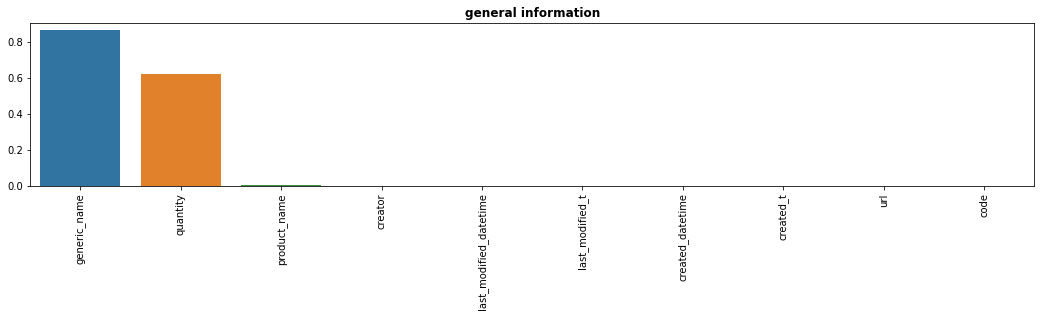

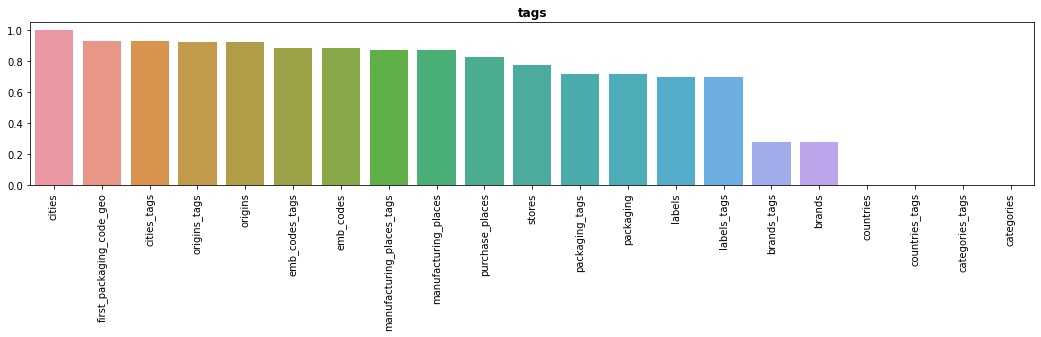

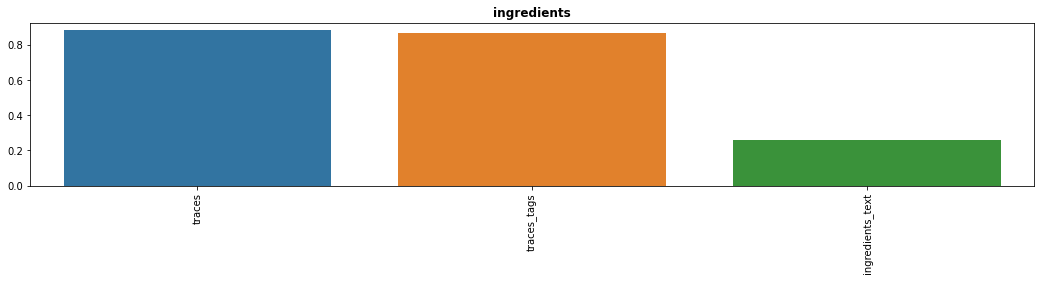

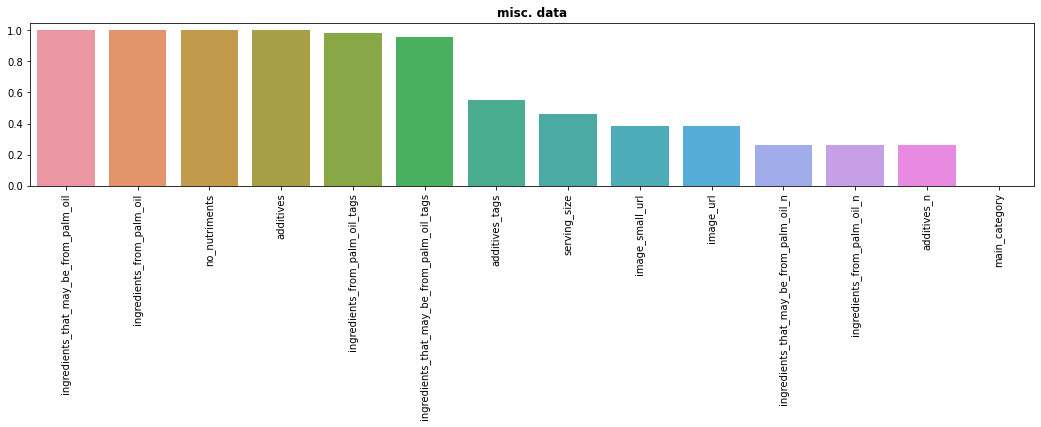

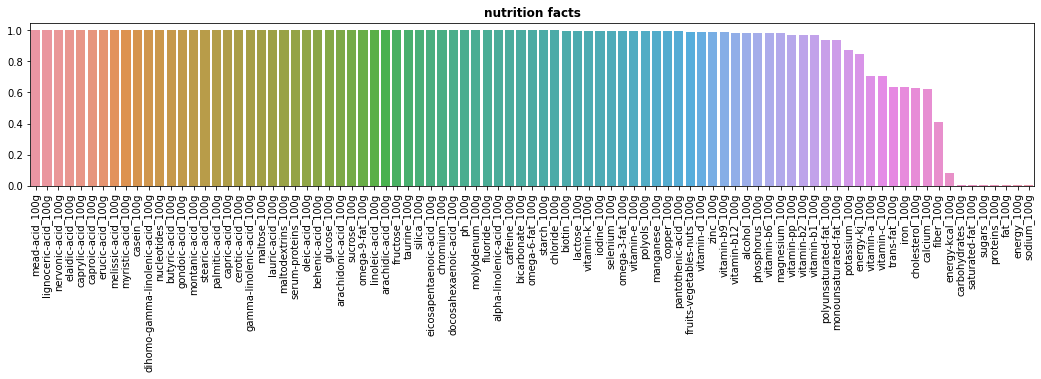

In [10]:
for cat in features_dict.keys():
    features = _df_nutriscore_score.columns[_df_nutriscore_score.columns.isin(features_dict[cat])]
    serie = (_df_nutriscore_score[features].isnull().sum() / len(_df_nutriscore_score[features])).sort_values(ascending = False)
    plt.figure(figsize = (18, 3))
    plt.title(cat, weight = 'bold')
    sns.barplot(serie.index, serie.values)
    plt.xticks(rotation = 90)
    plt.show()

Il y a beaucoup de valeur nulles pour les valeurs nutritionnelles des produits. De plus, le nutri-score des aliments repose sur le calcul d’un score unique et global prenant en compte, pour chaque aliment :

- une composante dite « négative » N composée des nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- une composante dite « positive » P composée des nutriments à limiter (énergie, acides gras saturés, sucres, sel).

Autrements dit le nutri-score d'un produit se calcule sur la base des valeurs nutritionnelles des aliments qui le compose, cela n'apporte pas de plus-value de réaliser la prédiction d'un score sur les éléments qui le compose. Il est plus interessant d'estimer le nutriscore à travers d'autres variables que liées aux valeurs nutritionnelles.

Quelles sont les variables hors valeurs nutritionnelles les plus complètes ?

In [11]:
# features without nutrition facts
_features = [f for key, value in features_dict.items() for f in value if key != 'nutrition facts']

In [12]:
# remove features in documentation that are not in dataframe
_features = list(set(_features).intersection(set(df.columns)))

Dans ces features certaines attraient à seulement à des considérations autres que les produits, comme code ou url, il convient de les supprimer.

In [13]:
_features_to_remove = ['code', 'url', 'creator', 'created_datetime', 'created_t', 'last_modified_datetime', 'last_modified_t']

_features = [f for f in _features if f not in _features_to_remove]

In [14]:
len(_features)

41

Le jeu de données est diviser (et enregistré) en:
- un jeu de prédiction (non labelisée)
- un jeu de test (20%)
- un jeu d'entrainement (80%)

Il est important de réaliser l'analyse des données indép

In [15]:
_df_nutriscore_score_wo_nutri_facts = df[_features].loc[df.nutriscore_score.notna()]

In [16]:
_serie = (_df_nutriscore_score_wo_nutri_facts.isnull().sum() / len(_df_nutriscore_score_wo_nutri_facts)).sort_values(ascending = False)

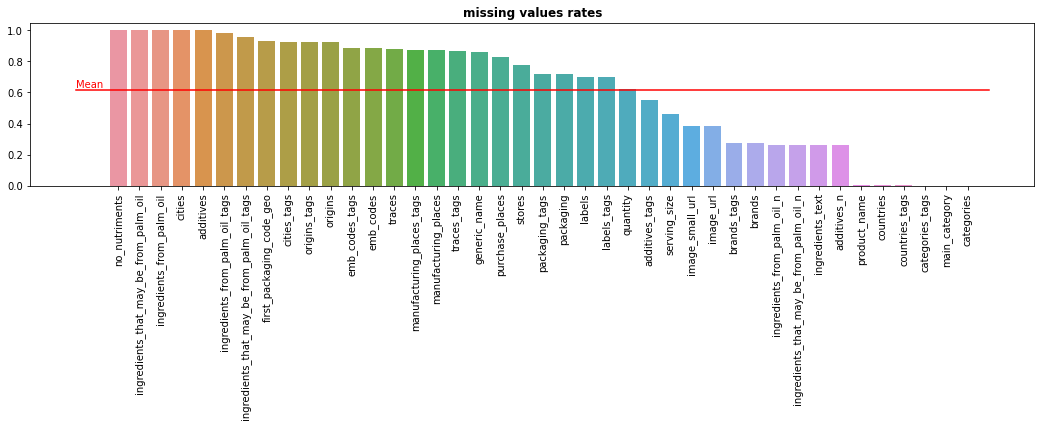

In [17]:
plt.figure(figsize = (18, 3))
plt.title('missing values rates', weight = 'bold')
sns.barplot(_serie.index, _serie.values)
plt.xticks(rotation = 90)
x = np.arange(-2, len(_features) + 1)
y = np.ones(len(_features) + 3)*_serie.mean()
plt.plot(x, y, c = 'red')
plt.text(x = -2, y = _serie.mean() + 0.02, s = 'Mean', c = 'red')
plt.show()

In [18]:
# missing values rates statistical description
round(_serie.describe(), 3)

count    41.000
mean      0.615
std       0.357
min       0.000
25%       0.277
50%       0.716
75%       0.923
max       1.000
dtype: float64

Le taux de valeurs manquantes est pour la moitié des variables supérieur à 71% ce qui reste très élevé. Dans un premier nn va s'interresser uniquement aux variables dont le taux est supérieur à la moyenne des taux de valeur manquantes (61,5%). S'il s'avère que ces variables ne suffisent pas pour estimer correctement le nutriscore, on reviendra sur les variables exclues dans un second en leur appliquant des méthodes d'imputation des valeurs manquantes plus puissante (cf. [MICE](https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained)).

In [19]:
_df = df[_serie[_serie < _serie.mean()].index]

In [20]:
# clear memory
del df
del _df_nutriscore_score
del _df_nutriscore_score_wo_nutri_facts
del _serie

## Data preprocessing

### additives_tags

In [21]:
_df.additives_tags.nunique()

91664

In [22]:
_df.additives_tags.value_counts()

en:e330                                                                                                 24603
en:e322,en:e322i                                                                                        16610
en:e440                                                                                                  6003
en:e415                                                                                                  4941
en:e300                                                                                                  3838
                                                                                                        ...  
en:e329,en:e330,en:e340,en:e340i,en:e968                                                                    1
en:e100,en:e300,en:e330,en:e341,en:e341i,en:e422,en:e440,en:e476,en:e500,en:e500ii,en:e503,en:e503ii        1
en:e1400,en:e1420,en:e14xx,en:e160a,en:e160c,en:e162,en:e163,en:e442,en:e476                                1
en:e140,en

In [58]:
_serie = _df.additives_tags.str.replace('en:', '').str.split(',')
_series =  pd.get_dummies(_serie.dropna().apply(pd.Series).stack(), prefix = 'add').sum(level = 0)
_features = [c for c in _series.columns if len(c) < 11]
_series = _series[_features]
_df = _df.merge(_series, left_index = True, right_index = True, how = 'left')

In [60]:
del _series

In [64]:
_df.additives_tags.isnull().sum() / len(_df)

0.7593812810027822

Le choix de garder ou non une variable au regard de son taux de valeurs manquantes doit prendre en considération :
- le type de variable (quantitative, catégorielle)
- le nombre de données présente et la tache de prédiction



In [24]:
for cat in features_dict.keys():
    if cat != 'nutrition facts':
        
    features = df_nutriscore_score.columns[df_nutriscore_score.columns.isin(features_dict[cat])]
    serie = (df_nutriscore_score[features].isnull().sum() / len(df_nutriscore_score[features])).sort_values(ascending = False)
    plt.figure(figsize = (18, 3))
    plt.title(cat)
    sns.barplot(serie.index, serie.values)
    plt.xticks(rotation = 90)
    plt.show()

IndentationError: expected an indented block (<ipython-input-24-24e5e43cb736>, line 4)

In [ ]:
features_by_missing_values = (df_nutriscore_score.isnull().sum() / len(df_nutriscore_score)).sort_values()

In [ ]:
print(f"""
missing values:
{'-'*20}
mean: {features_by_missing_values.mean():.2%}
median: {features_by_missing_values.quantile(0.5):.2%}
quantile 25%: {features_by_missing_values.quantile(0.25):.2%}
quantile 10%: {features_by_missing_values.quantile(0.1):.2%}
""")

In [ ]:
plt.figure()
plt.title('Distribution of missing values')
sns.distplot(features_by_missing_values, kde= False)
plt.show()

Je ne garde que les variables qui dont le missing rate est inférieur au dernier quartile 

In [ ]:
features_by_missing_values[features_by_missing_values < features_by_missing_values.quantile(0.25)]

**Idée 1: image_url**

- extraire les images
- construires des features (couleurs + noyaux de convolutions)
- est-ce que des corrélations entre le nutriscore et ces features peuvent-elles être établies ?

**Idée 2: prendre un ensemble de variable qui peu de missing values**
Exemples:
- product_name
- labels,

In [ ]:
variables_description.split('#')[1:]

In [ ]:
for i in variables_description.split('#')[1:]:
    print(i.split('\n\n')[0].strip())
    print([j.split(':')[0] for j in i.split('\n\n')[1].strip().split('\n')])
    print()

In [ ]:
df.states.value_counts()

In [ ]:
sample = df.sample(1000)

In [ ]:
serie = (sample.isnull().sum() / len(sample)).sort_values(ascending = False)

In [ ]:
plt.figure(figsize = (20, 4))
sns.barplot(serie.index, serie.values)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
plt.figure(figsize = (20, 4))
plt.scatter(x = [], y = [])
plt.show()

In [ ]:
df.isnull().sum(axis = 1)

In [ ]:
type(df.sample(10).info())

In [ ]:
'product_name', 'generic_name', 'quantity', 'packaging'

In [ ]:
df.packaging_tags.value_counts()

In [ ]:
df.sample(5)

In [ ]:
df.nutriscore_score.describe()

In [ ]:
sns.distplot(df.nutriscore_score)
plt.show()

In [ ]:
sns.barplot(x = df.nutriscore_grade.value_counts().index, y = df.nutriscore_grade.value_counts().values)

In [ ]:
df.nutriscore_grade.value_counts()

In [ ]:
df.nutriscore_score.isnull().sum() / len(df)

In [ ]:
df.nutriscore_grade.isnull().sum() / len(df)

In [ ]:
dict(df.manufacturing_places_tags.value_counts())

In [ ]:
dict(df.manufacturing_places.value_counts())

In [ ]:
countries_dict = {
    'france': ['france', 'francia', 'bretagne', 'frankreich', 'fr', 'saint-gilles-croix-de-vie' 'alsace', 'corse', 'vendée', 'toulouse', 'provence', 'française' 'strasbourg'],
    'italie': ['italie', 'italia', 'italy', 'italien' 'it'],
    'angleterre': ['angleterre', 'united-kingdom', 'royaume-uni', 'england', 'uk', 'écosse', 'royaume uni'],
    'belgique': ['belgique', 'belgium', 'be'],
    'allemagne': ['allemagne', 'germany', 'deutshland', 'germania', 'alemania'],
    'espagne': ['espagne', 'spain', 'españa', 'es'],
    'luxembourg': ['luxembourg', 'lux'],
    'suisse': ['suisse', 'switzerland']
}

In [ ]:
    print('ok')

In [ ]:
def clean_manufacturing_places(x, countries_dict):
    value = ''
    for country in countries_dict.keys():
        if re.match('|'.join(countries_dict[country]), x.lower()):
            value = country
    if value == '':
        return np.NaN
    else:
        return value

In [ ]:
df['clean_manufacturing_places'] = df.manufacturing_places.dropna().progress_apply(lambda x: clean_manufacturing_places(x, countries_dict))

In [ ]:
np.NaN.isnull()

In [ ]:
df.manufacturing_places.dropna()

In [ ]:
df['clean_manufacturing_places'].value_counts()

In [ ]:
France, Italie, Belgique, Allemagne, Espagne
(Fr France), (It, Italia), (be, Belgium), (De,Deustshland

In [ ]:
sns.heatmap(data = df.nutriscore_score.isnull())

In [ ]:
df.sample()

In [ ]:
dict(df.origins_en.value_counts())

### Data cleaning

In [ ]:
origins_tags_preprocessings = df.origins_tags.str.split(',').apply(pd.Series)

In [ ]:
origins_tags_processings.transform(lambda x: x[3:])

In [ ]:
origins_tags_process

In [ ]:
def france_origins_preprocessing(x):
    if 'france' in x or 'fr' in x 
        return france

In [ ]:
df.origins_clean